# EDA: CheXpert

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [10]:
# need this to change to necessary directory
os.chdir('/Users/joeai/Springboard/capstone_2')

In [11]:
os.getcwd()

'/Users/joeai/Springboard/capstone_2'

In [12]:
# import test_folder to perform exploratory data analysis
from test_folder import eda
path = eda.eda_path(os.getcwd())
path

PosixPath('/Users/joeai/Springboard/capstone_2')

In [13]:
# create train and valid dfs
train_df, valid_df = eda.load_data(path);

In [14]:
# print info on dataframes
eda.print_info([train_df, valid_df])

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null int64
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null float64
Enlarged Cardiomediastinum    44839 non-null float64
Cardiomegaly                  46203 non-null float64
Lung Opacity                  117778 non-null float64
Lung Lesion                   11944 non-null float64
Edema                         85956 non-null float64
Consolidation                 70622 non-null float64
Pneumonia                     27608 non-null float64
Atelectasis                   68443 non-null float64
Pneumothorax                  78934 non-null float64
Pleural Effusion              133211 non-null float64
Pleural Other                 6492 non

## Observations 

As we can see above, `train_df` has quite a few `NaN`s which isn't good. However, upon further investigation of Stanford's Machine Learning GitHub page, we can clarify that missing values mean that no mention of that particular pathology was extracted via the labeler. 

Stanford treated those cases as negative (i.e. `0`) when they created their own model. So we can begin by inputing `0` for these pathological columns.

In [15]:
train_df = eda.fill_pathologies_nan(train_df);

Path                          0.000000
Sex                           0.000000
Age                           0.000000
Frontal/Lateral               0.000000
AP/PA                         0.144964
No Finding                    0.000000
Enlarged Cardiomediastinum    0.000000
Cardiomegaly                  0.000000
Lung Opacity                  0.000000
Lung Lesion                   0.000000
Edema                         0.000000
Consolidation                 0.000000
Pneumonia                     0.000000
Atelectasis                   0.000000
Pneumothorax                  0.000000
Pleural Effusion              0.000000
Pleural Other                 0.000000
Fracture                      0.000000
Support Devices               0.000000
dtype: float64


## _Observations_

Looks like we're good to go...except for the `AP/PA` column. Let's take a look at what this column represents.

In [25]:
train_df['AP/PA'].head(10)

0     AP
1     AP
2     AP
3    NaN
4     AP
5     PA
6    NaN
7     PA
8    NaN
9     AP
Name: AP/PA, dtype: object

In [29]:
train_df['AP/PA'].value_counts(dropna=False)

AP     161590
NaN     32387
PA      29420
LL         16
RL          1
Name: AP/PA, dtype: int64

In [28]:
train_df['AP/PA'].value_counts(normalize=True, dropna=False)

AP     0.723276
NaN    0.144964
PA     0.131684
LL     0.000072
RL     0.000004
Name: AP/PA, dtype: float64

## What do `AP`, `PA` mean?

Simply put, it has to do with the positioning of the patient. 

`PA` stands for posterioranterior which is obtained when the patient is in a standing position, facing the cassette and the x-ray tube is approximately 72 inches away.

`AP` stands for anteriorposterior which is when the patient is lying down and the x-ray tube is only 40 inches from the patient. [(Source)](https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html)

It also looks like we have a very small number of observations that were labeled as either `LL` or `RL`. 

I'll have to do some further investigation into these particular labels...

However, since we'll be focus on labeling images, we won't have to worry too much about the unlabeled observations since we'll be feeding the images directly into the deep learning model. 

## _Focus: Sex & Age_

In [30]:
train_df['Sex'] = train_df['Sex'].astype('category')
train_df['Sex'].dtype

CategoricalDtype(categories=['Female', 'Male', 'Unknown'], ordered=False)

In [32]:
train_df['Sex'].value_counts(dropna=False)

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

In [33]:
train_df['Sex'].value_counts(normalize=True)

Male       0.593678
Female     0.406317
Unknown    0.000004
Name: Sex, dtype: float64

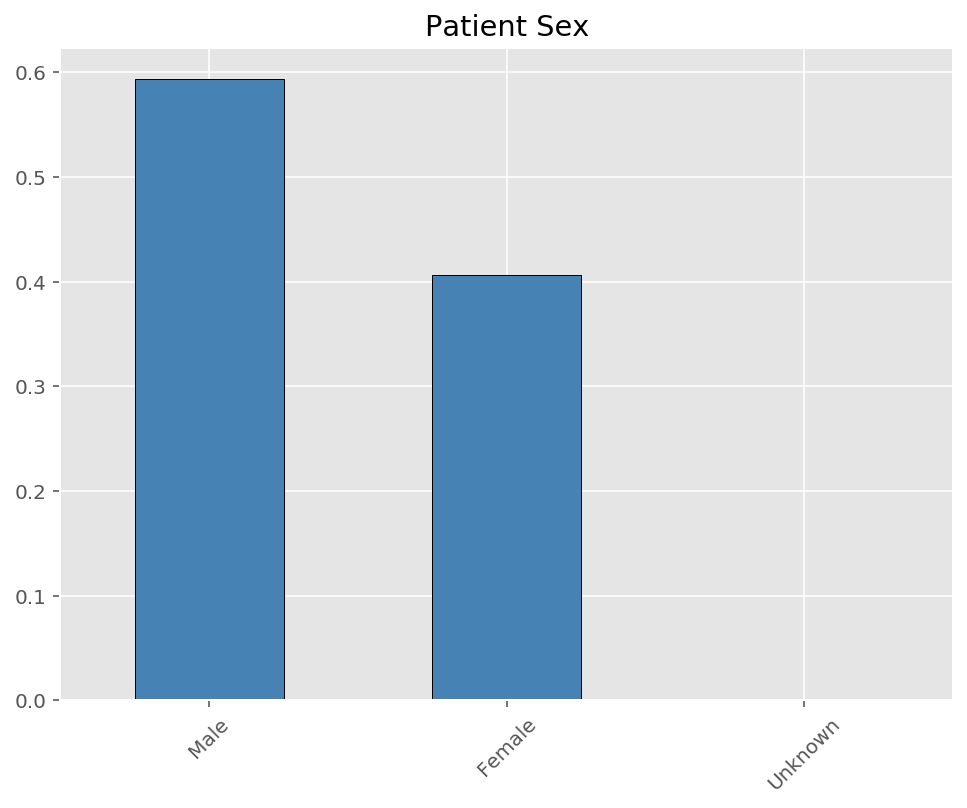

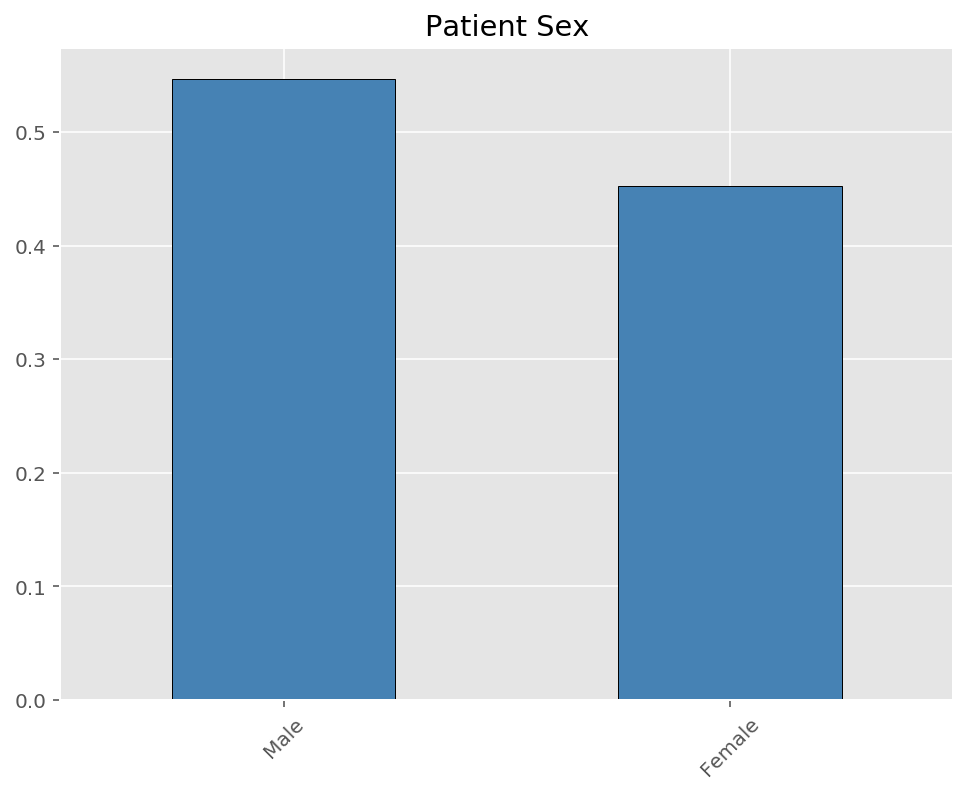

In [39]:
eda.patient_sex_bar_graph([train_df, valid_df])

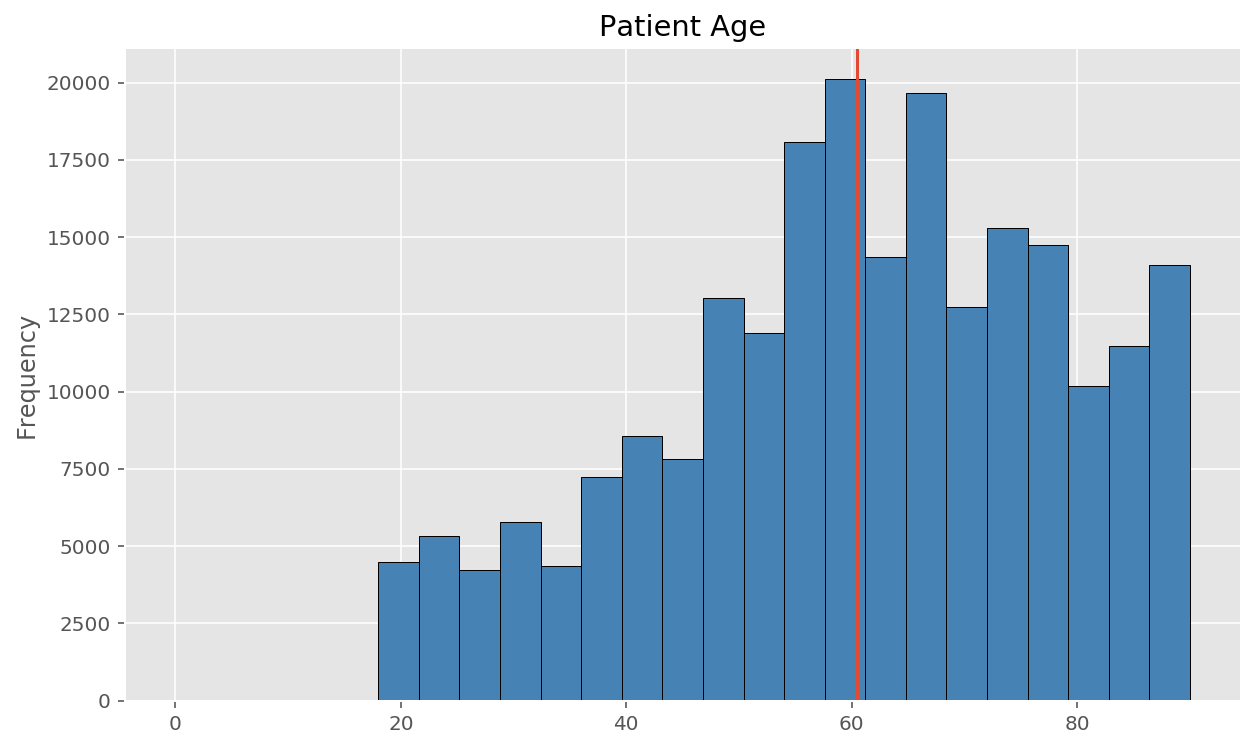

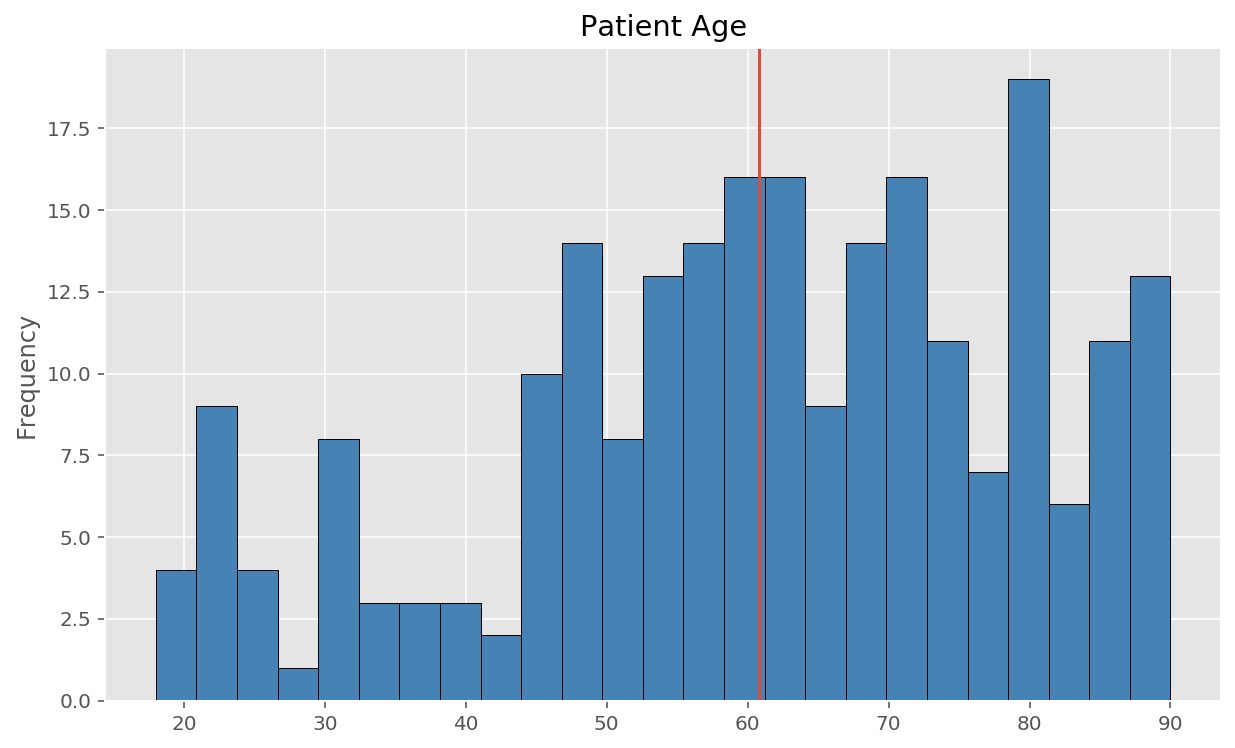

In [45]:
eda.patient_age_hist([train_df, valid_df])

## _Analyze Pathologies_

In [51]:
eda.analyze_pathologies(train_df)

Atelectasis
------------------------------
 0    0.699594
-1    0.151016
 1    0.149391
Name: Atelectasis, dtype: float64

Cardiomegaly
------------------------------
 0    0.842951
 1    0.120852
-1    0.036197
Name: Cardiomegaly, dtype: float64

Consolidation
------------------------------
 0    0.809658
-1    0.124173
 1    0.066169
Name: Consolidation, dtype: float64

Edema
------------------------------
 0    0.708031
 1    0.233853
-1    0.058116
Name: Edema, dtype: float64

Enlarged Cardiomediastinum
------------------------------
 0    0.896152
-1    0.055516
 1    0.048332
Name: Enlarged Cardiomediastinum, dtype: float64

Fracture
------------------------------
 0    0.956663
 1    0.040463
-1    0.002874
Name: Fracture, dtype: float64

Lung Lesion
------------------------------
 0    0.952223
 1    0.041116
-1    0.006660
Name: Lung Lesion, dtype: float64

Lung Opacity
------------------------------
 0    0.502363
 1    0.472580
-1    0.025057
Name: Lung Opacity, dtype: float

# _Analyze Uncertain, Positive, and Negative Labels Amongst Pathologies_

In [22]:
pathology_list = sorted(list(train_df.columns[5:]))
pathology_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Fracture',
 'Lung Lesion',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']

In [31]:
# create a dictionary that contains the number of uncertain labels for each pathology
uncertainty_dict = eda.uncertainty_dict(pathology_list, train_df)

Atelectasis: 33739 or 15.1% of observations in that column.
Cardiomegaly: 8087 or 3.62% of observations in that column.
Consolidation: 27742 or 12.42% of observations in that column.
Edema: 12984 or 5.81% of observations in that column.
Enlarged Cardiomediastinum: 12403 or 5.55% of observations in that column.
Fracture: 642 or 0.29% of observations in that column.
Lung Lesion: 1488 or 0.67% of observations in that column.
Lung Opacity: 5598 or 2.51% of observations in that column.
No Finding: 0 or 0.0% of observations in that column.
Pleural Effusion: 11628 or 5.2% of observations in that column.
Pleural Other: 2653 or 1.19% of observations in that column.
Pneumonia: 18770 or 8.4% of observations in that column.
Pneumothorax: 3145 or 1.41% of observations in that column.
Support Devices: 1079 or 0.48% of observations in that column.


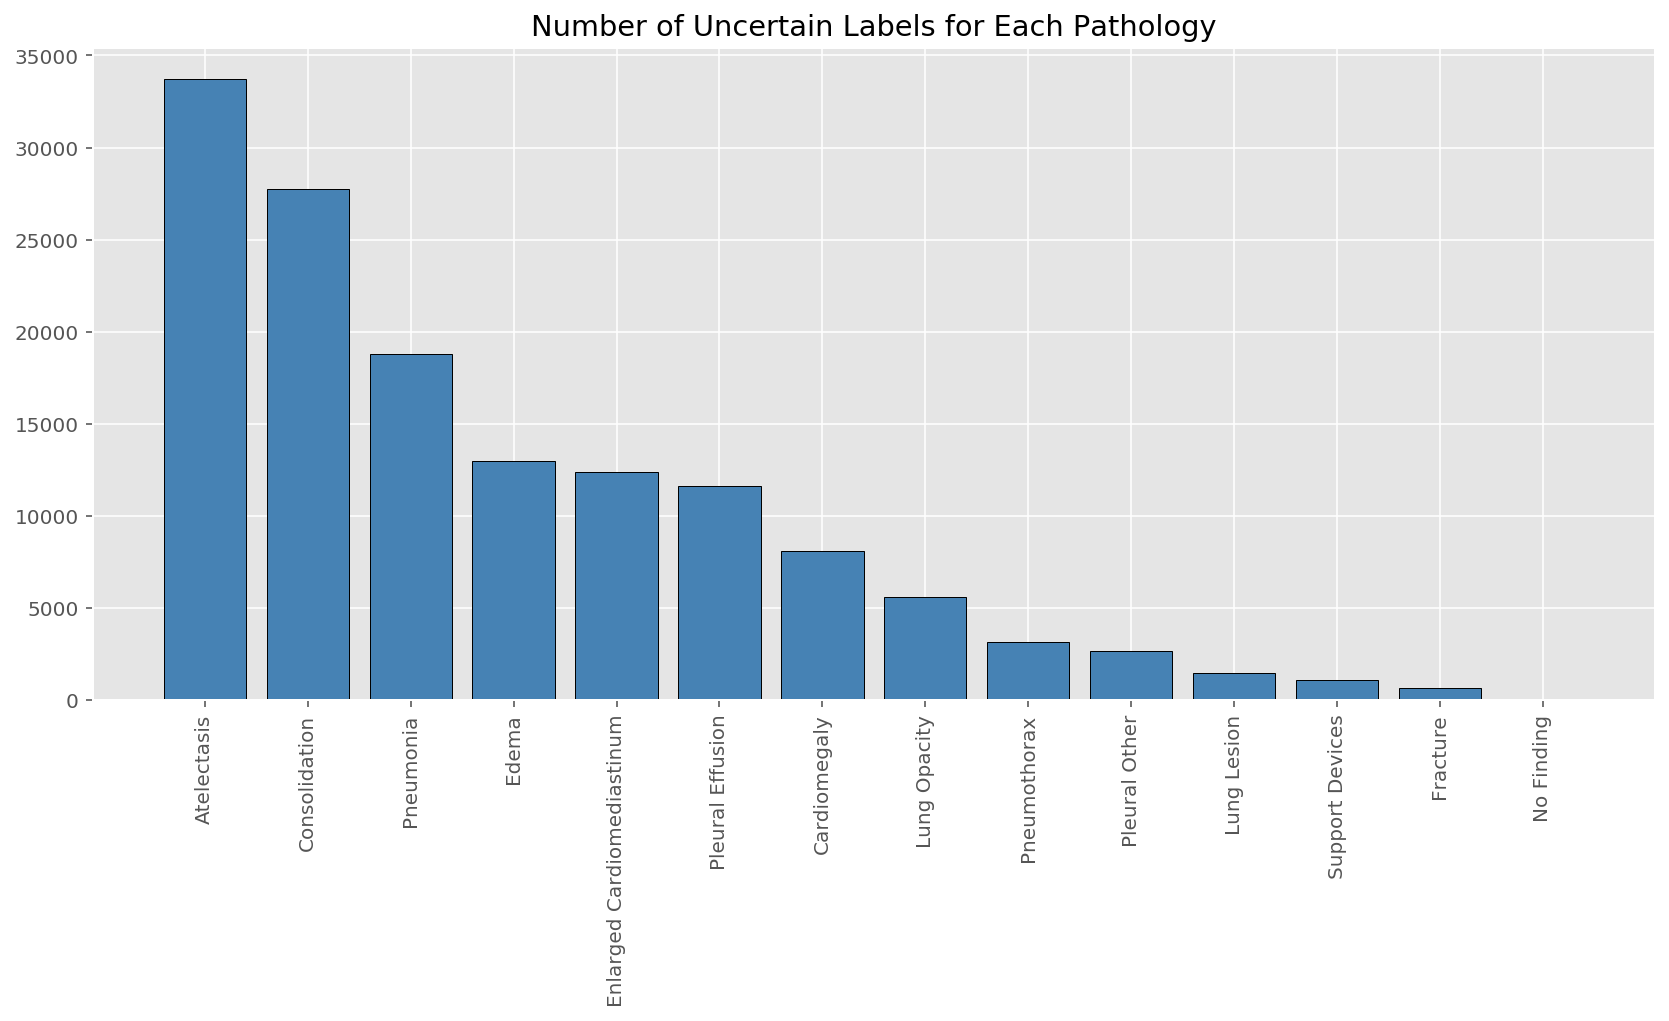

In [36]:
# visualization of uncertain labels for each pathology
eda.plt_dict(uncertainty_dict, 'Uncertain')

In [37]:
# create dictionary which stores negative observations for each pathology
negative_dict = eda.negative_dict(pathology_list, train_df);

Atelectasis: 156299 or 69.96% of observations in that column.
Cardiomegaly: 188327 or 84.3% of observations in that column.
Consolidation: 180889 or 80.97% of observations in that column.
Edema: 158184 or 70.8% of observations in that column.
Enlarged Cardiomediastinum: 200213 or 89.62% of observations in that column.
Fracture: 213732 or 95.67% of observations in that column.
Lung Lesion: 212740 or 95.22% of observations in that column.
Lung Opacity: 112235 or 50.24% of observations in that column.
No Finding: 201033 or 89.98% of observations in that column.
Pleural Effusion: 125599 or 56.22% of observations in that column.
Pleural Other: 217238 or 97.24% of observations in that column.
Pneumonia: 198605 or 88.9% of observations in that column.
Pneumothorax: 200821 or 89.89% of observations in that column.
Support Devices: 106334 or 47.6% of observations in that column.


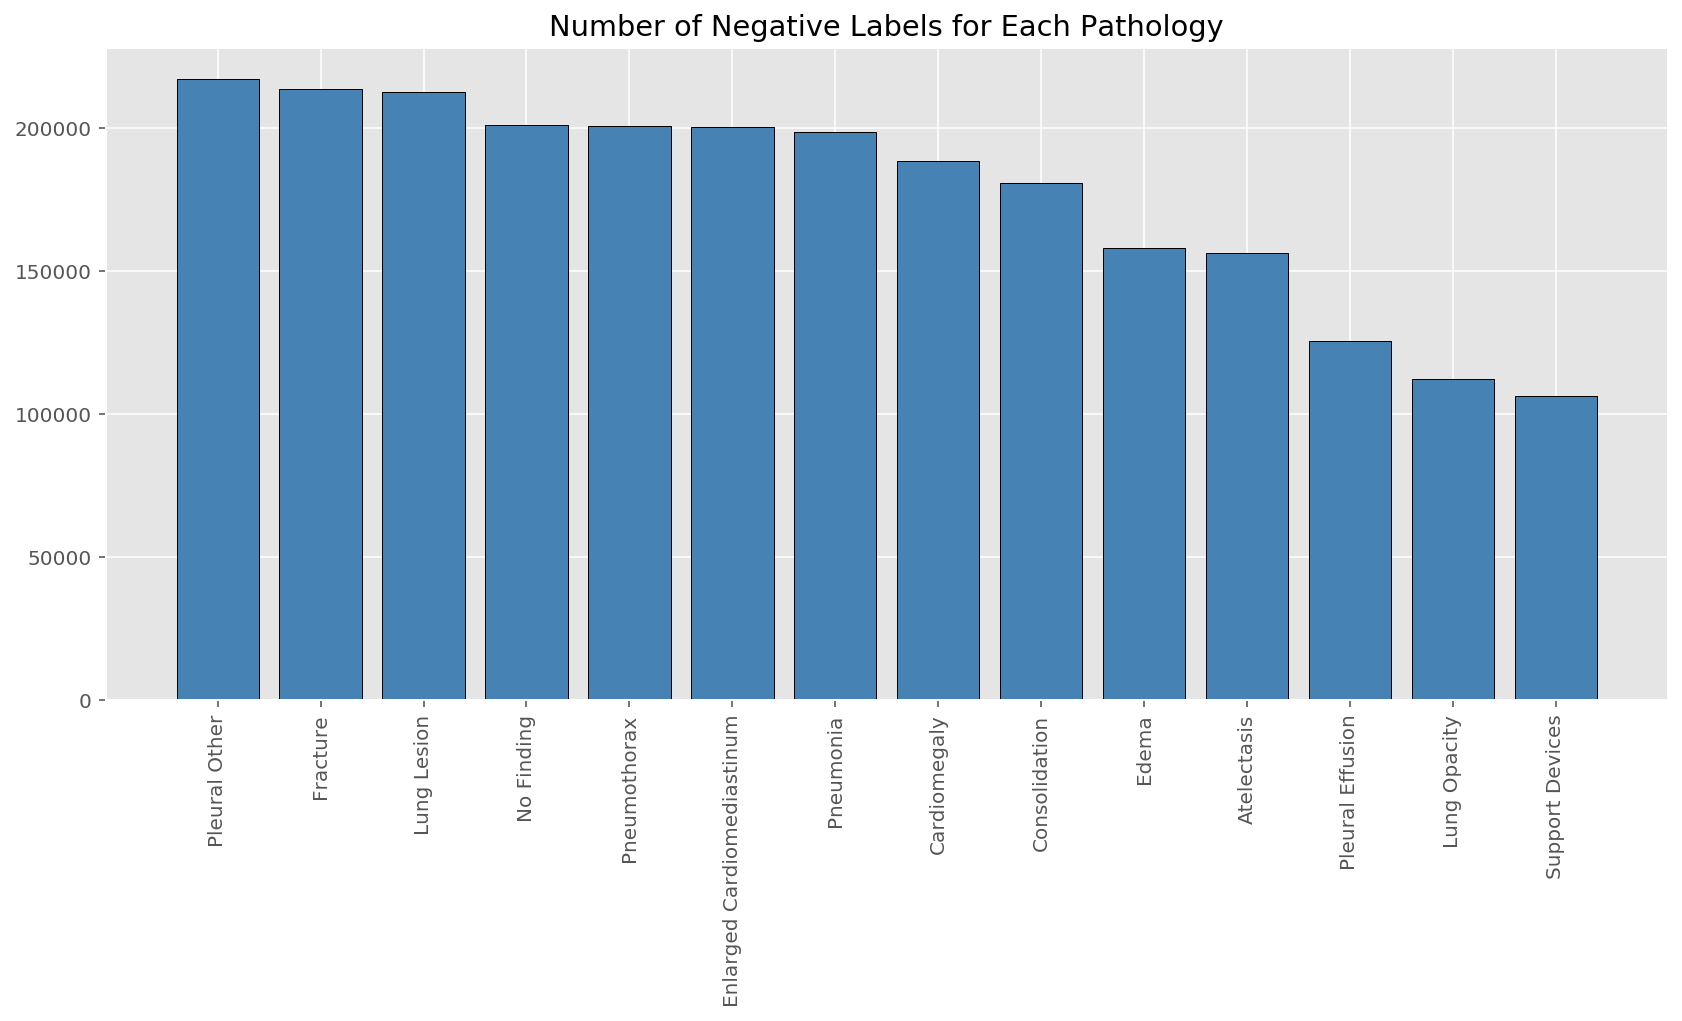

In [38]:
# visualization of negative labels for each pathology
eda.plt_dict(negative_dict, 'Negative')

In [39]:
# create dictionary storing positive observations for each pathology
positive_dict = eda.positive_dict(pathology_list, train_df);

Atelectasis: 33376 or 14.94% of observations in that column.
Cardiomegaly: 27000 or 12.09% of observations in that column.
Consolidation: 14783 or 6.62% of observations in that column.
Edema: 52246 or 23.39% of observations in that column.
Enlarged Cardiomediastinum: 10798 or 4.83% of observations in that column.
Fracture: 9040 or 4.05% of observations in that column.
Lung Lesion: 9186 or 4.11% of observations in that column.
Lung Opacity: 105581 or 47.26% of observations in that column.
No Finding: 22381 or 10.02% of observations in that column.
Pleural Effusion: 86187 or 38.58% of observations in that column.
Pleural Other: 3523 or 1.58% of observations in that column.
Pneumonia: 6039 or 2.7% of observations in that column.
Pneumothorax: 19448 or 8.7% of observations in that column.
Support Devices: 116001 or 51.92% of observations in that column.


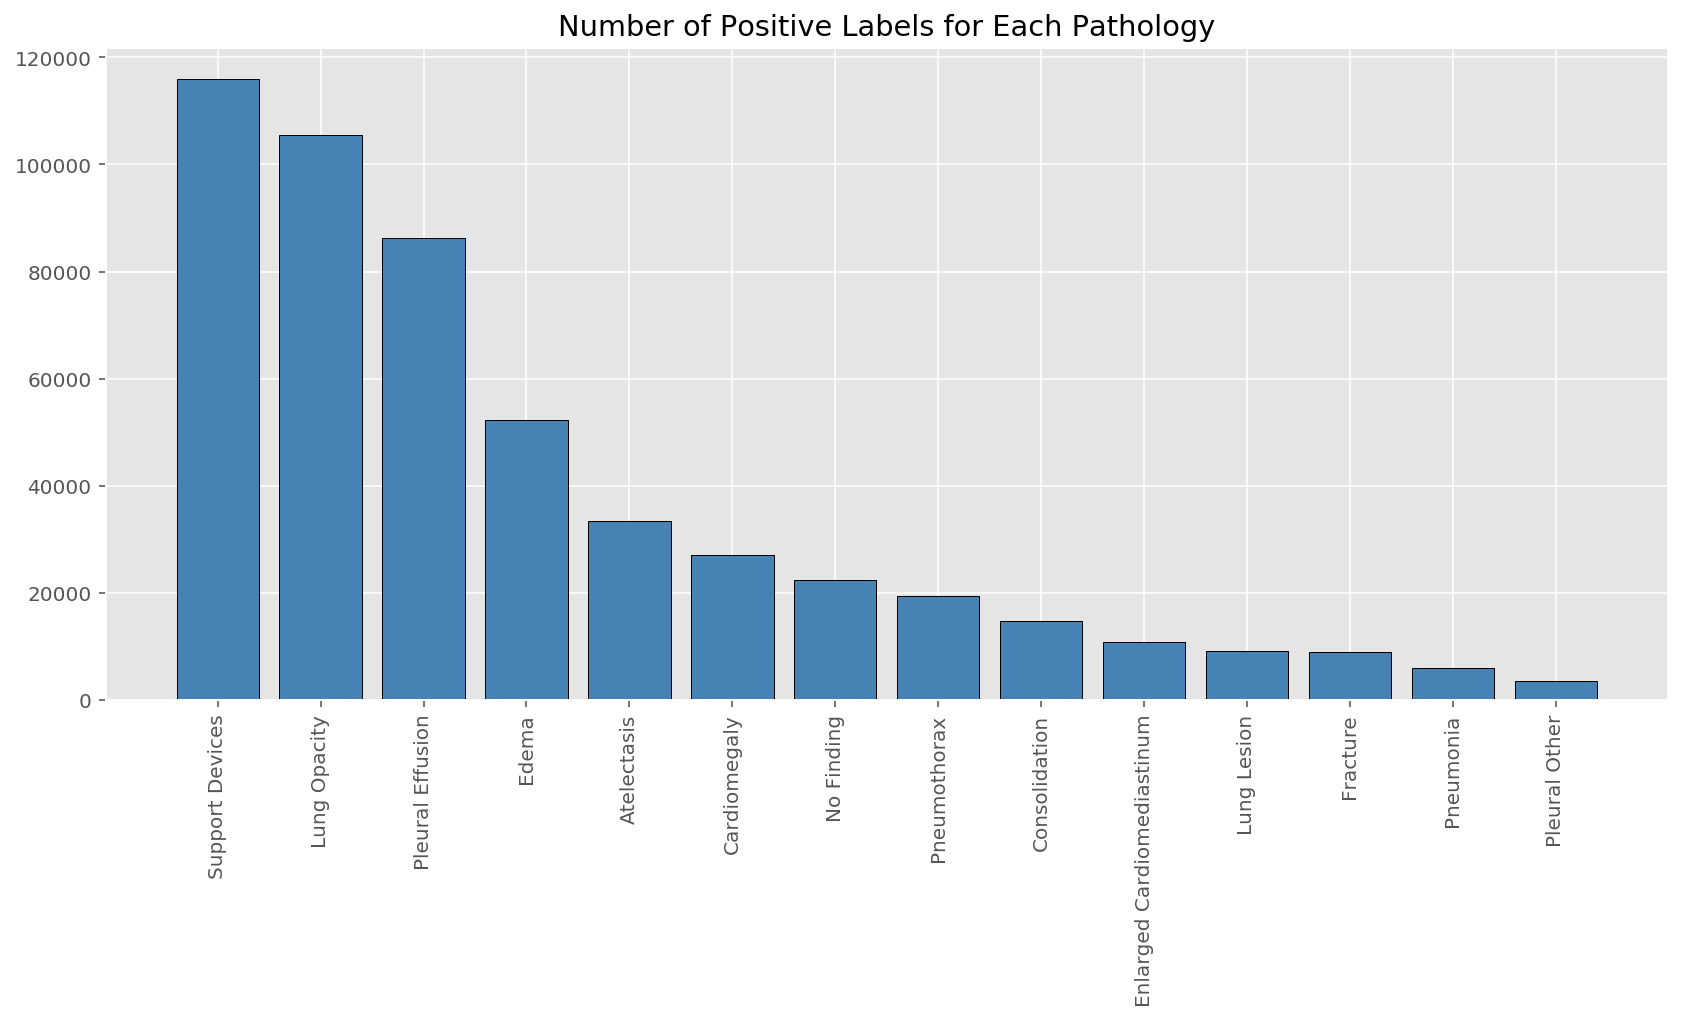

In [40]:
eda.plt_dict(positive_dict, 'Positive')

# _Deep Dive: Atelectasis_

Since the pathology `Atelectasis` has the highest number of uncertain labels, I figured it might be interesting to see if there is anything about this population that we might be to better understand.

In [52]:
# create atelectasis data frame
atelectasis_df = train_df[train_df['Atelectasis'] == -1]

In [53]:
atelectasis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33739 entries, 1 to 223410
Data columns (total 19 columns):
Path                          33739 non-null object
Sex                           33739 non-null object
Age                           33739 non-null int64
Frontal/Lateral               33739 non-null object
AP/PA                         29863 non-null object
No Finding                    33739 non-null int64
Enlarged Cardiomediastinum    33739 non-null int64
Cardiomegaly                  33739 non-null int64
Lung Opacity                  33739 non-null int64
Lung Lesion                   33739 non-null int64
Edema                         33739 non-null int64
Consolidation                 33739 non-null int64
Pneumonia                     33739 non-null int64
Atelectasis                   33739 non-null int64
Pneumothorax                  33739 non-null int64
Pleural Effusion              33739 non-null int64
Pleural Other                 33739 non-null int64
Fracture           

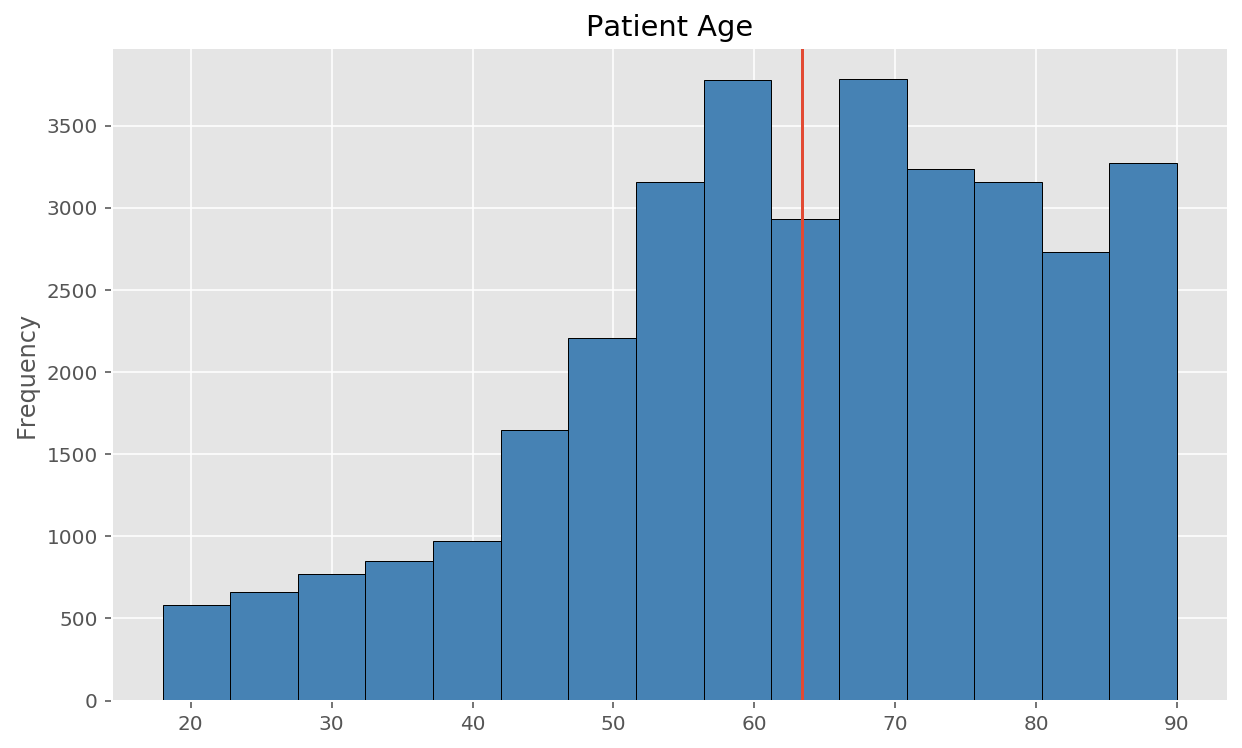

In [56]:
plt.figure()
atelectasis_df['Age'].plot(kind='hist', color='steelblue', edgecolor='black', bins=15, figsize=(10,6))
plt.axvline(x=np.mean(atelectasis_df['Age']))
plt.title('Patient Age');

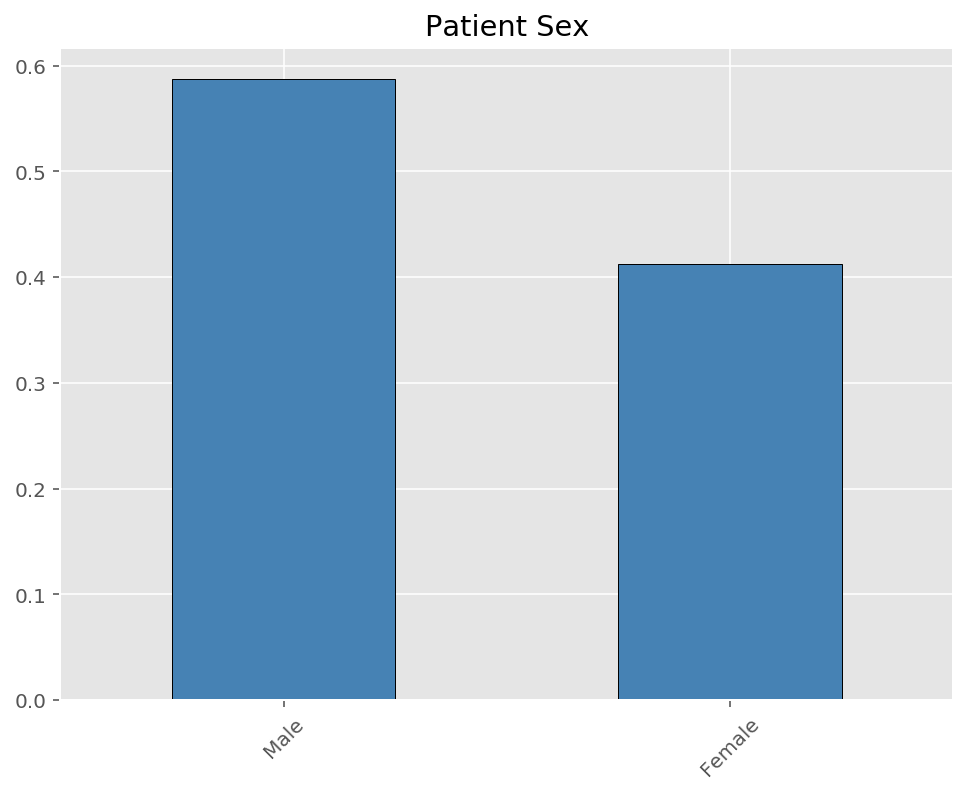

In [72]:
plt.figure(figsize=(8,6))
atelectasis_df['Sex'].value_counts(normalize=True).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Patient Sex')
plt.xticks(rotation=45);